In [246]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

Q1_QRELS_FILE = "../query_qrels/query_1.txt"
Q2_QRELS_FILE = "../query_qrels/query_2.txt"
Q3_QRELS_FILE = "../query_qrels/query_3.txt"
Q4_QRELS_FILE = "../query_qrels/query_4.txt"
Q5_QRELS_FILE = "../query_qrels/query_5.txt"

Queries = [Q1, Q2,Q3, Q4, Q5]

Q1 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=(Antes_de_utilizar%3Aamamentar~3%20AND%20(Antes_de_utilizar%3A%22amamentação%20Não%22~4))%20OR%20(Antes_de_utilizar%3Aaleitamento%20AND%20(Antes_de_utilizar%3A%22aleitamento%20Não%22~4))%20OR%20(Antes_de_utilizar%3Agravidez%20AND%20(Antes_de_utilizar%3A%22grávida%20Não%22%5E2~4))&useParams=%3Djson&wt=json"
Q2 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=O_que_e_e_para_que_e_utilizado%3Aantibiotico%20AND%20(O_que_e_e_para_que_e_utilizado%3Ainfecao%5E2~4%20AND%20O_que_e_e_para_que_e_utilizado%3Amaxil*%20)&useParams=&wt=json"
Q3 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=Vias_de_Administracao%3A%22Uso%20oftálmico%22%20AND%20(Duracao_do_Tratamento%3A%22Média%20Duração%22~2%20OR%20Duracao_do_Tratamento%3A%22Curta%20Duração%22%5E2)%20AND%20Generico%3ANão&useParams=&wt=json"
Q4 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=O_que_e_e_para_que_e_utilizado%3A%22Doenca%20mental%22~0%20OR%20O_que_e_e_para_que_e_utilizado%3Adepressao%20OR%20O_que_e_e_para_que_e_utilizado%3Aproblemas%20mentais%20OR%20O_que_e_e_para_que_e_utilizado%3Aesquizofrenia%20OR%20O_que_e_e_para_que_e_utilizado%3Aansiedade%20OR%20O_que_e_e_para_que_e_utilizado%3Astress%20OR%20O_que_e_e_para_que_e_utilizado%3Aperturbaç*%20OR%20O_que_e_e_para_que_e_utilizado%3Aobsess*%20OR%20O_que_e_e_para_que_e_utilizado%3Acompuls*&useParams=&wt=json"
Q5 = "http://localhost:8983/solr/medicines/select?defType=lucene&indent=true&q.op=OR&q=(O_que_e_e_para_que_e_utilizado%3A%20%22doença%20coração%22%5E2~3%20OR%20O_que_e_e_para_que_e_utilizado%3A%20%22doença%20pulmonar%22~3)%20AND%20Antes_de_utilizar%3A%20%22não%20crianças%22~6&useParams=&wt=json"

QUERY_URL = Q2
QRELS_FILE = Q2_QRELS_FILE

In [247]:
# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']

print(results)

[{'Product_name': ['Claritromicina Azevedos'], 'Active_substance': 'Clarithromycin', 'Route_of_administration': 'Intravenous Use', 'Product_authorisation_country': 'Portugal', 'Marketing_authorisation_holder': 'Laboratórios Azevedos - Indústria Farmacêutica, S.A.', 'Pharmacovigilance_system_master_file_location': 'Portugal', 'Pharmacovigilance_enquiries_email_address': 'farmacovigilancia@azevedos-sa.pt', 'Pharmacovigilance_enquiries_telephone_number': '+351214725927', 'Lowest_PVP': '6.25', 'Substancia_Ativa_DCI': 'Claritromicina', 'Forma_Farmaceutica': 'Comprimido revestido por película', 'Dosagem': '500 mg', 'Titular_de_AIM': 'Laboratórios Azevedos - Indústria Farmacêutica, S.A.', 'Generico': 'Sim', 'Vias_de_Administracao': 'Via oral', 'Grupo_de_Produto': 'Genérico', 'Numero_de_Processo': '03/H/0190/002', 'AIM': 'Autorizado', 'Data': '03/10/2003', 'Classificacao_Quanto_a_Dispensa': 'MSRM', 'Duracao_do_Tratamento': 'Curta ou Média Duração', 'O_que_e_e_para_que_e_utilizado': 'O que é Cl

In [248]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['Product_name'][0] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['Product_name'][0] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

In [249]:
# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('results.tex','w') as tf:
    tf.write(df.to_latex())


'Precision values:'

[1.0, 1.0]

'Recall values:'

[0.5, 1.0]

'MY Interpolated Recall'

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

'Interpolated precision'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

'My Interpolated precision'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

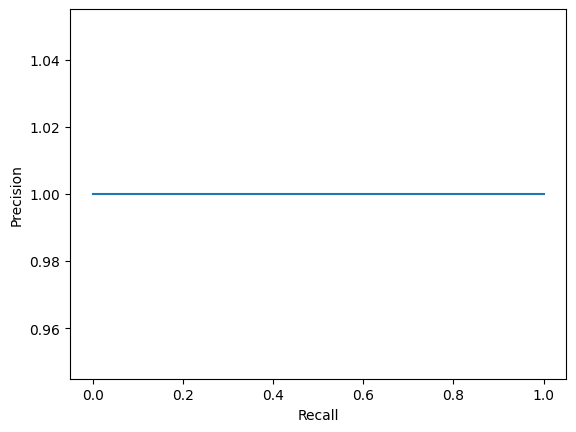

In [250]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

display("Precision values:", precision_values)
display("Recall values:", recall_values)

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}


# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.0, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))


my_interpolated_recall = [step for step in np.arange(0.0, 1.1, 0.1)]
display("MY Interpolated Recall", my_interpolated_recall)


# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]


disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)


my_interpolated_precision = [precision_recall_match.get(r) for r in my_interpolated_recall]
display("Interpolated precision", [precision_recall_match.get(r) for r in recall_values])
display("My Interpolated precision", my_interpolated_precision)


disp.plot()
plt.savefig('precision_recall.png')
